In [23]:
# =============================================================
# 📦 Cell 1 – Imports
# =============================================================
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array
)
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import plot_model
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, random
from sklearn.metrics import confusion_matrix, classification_report


In [24]:
# =============================================================
# 📂 Cell 2 – Paths & Hyper‑parameters
# =============================================================
base_dir   = '/kaggle/input/maize-leaf-dataset/split_dataset'   # <- adjust
img_size   = (224, 224)     # MobileNetV2 default
batch_size = 32
epochs     = 20

train_path = os.path.join(base_dir, 'train')
val_path   = os.path.join(base_dir, 'val')
test_path  = os.path.join(base_dir, 'test')


In [25]:
# =============================================================
# 🌀 Cell 3 – Data Generators
# =============================================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    zoom_range=0.25, horizontal_flip=True, brightness_range=[0.7,1.3])

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical')

val_gen = val_test_datagen.flow_from_directory(
    val_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical')

test_gen = val_test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False)


Found 4141 images belonging to 4 classes.
Found 516 images belonging to 4 classes.
Found 522 images belonging to 4 classes.


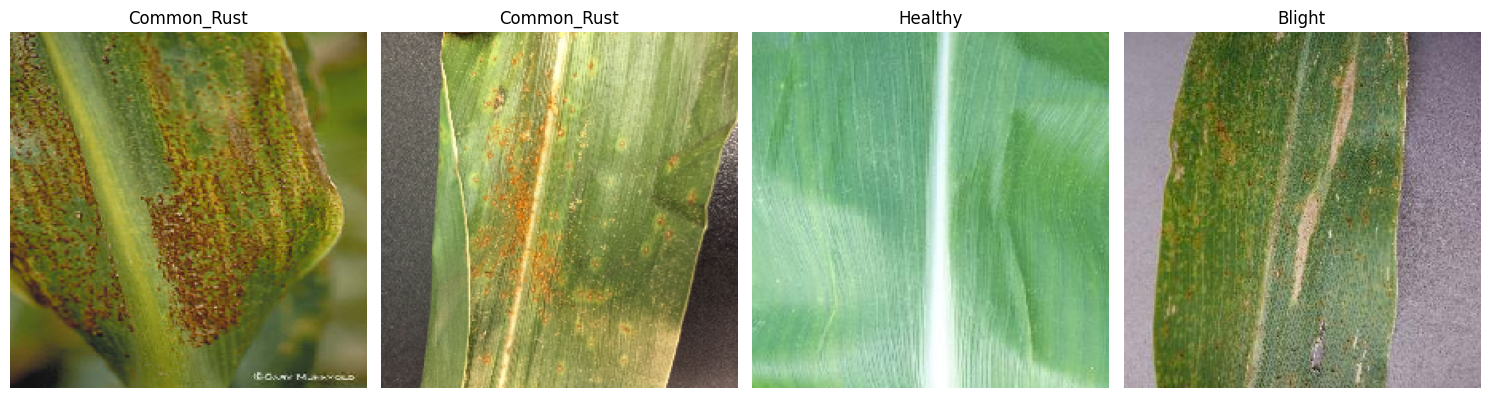

In [26]:
# =============================================================
# 🖼️ Cell 4 – Show Random Images
# =============================================================
def show_random(folder, n=4):
    classes = [c for c in os.listdir(folder) if os.path.isdir(os.path.join(folder, c))]
    plt.figure(figsize=(15,4))
    for i in range(n):
        cls  = random.choice(classes)
        file = random.choice(os.listdir(os.path.join(folder, cls)))
        img  = load_img(os.path.join(folder, cls, file), target_size=img_size)
        plt.subplot(1,n,i+1); plt.imshow(img); plt.title(cls); plt.axis('off')
    plt.tight_layout(); plt.show()

show_random(train_path)


In [27]:
# =============================================================
# 🧠 Cell 5 – Build MobileNet V2 Transfer‑Learning Model
# =============================================================
base_model = MobileNetV2(include_top=False, weights='imagenet',
                         input_shape=img_size + (3,))
base_model.trainable = False   # freeze

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(base_model.input, outputs, name='MobileNetV2_TL')

model.compile(optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

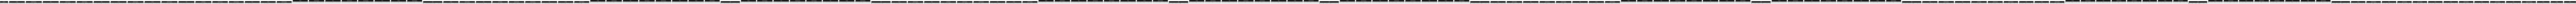

In [28]:
# =============================================================
# 🖨️ Cell 6 – Summary & Architecture Diagram
# =============================================================
model.summary()
plot_model(model, to_file='mobilenetv2_arch.png',
           show_shapes=True, rankdir='LR')
from IPython.display import Image; Image('mobilenetv2_arch.png')


In [29]:
# =============================================================
# 🚂 Cell 7 – Train
# =============================================================
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 76s 513ms/step - accuracy: 0.5982 - loss: 1.0018 - val_accuracy: 0.8469 - val_loss: 0.3687
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - accuracy: 0.8573 - loss: 0.3818 - val_accuracy: 0.8760 - val_loss: 0.2878
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - accuracy: 0.8760 - loss: 0.3190 - val_accuracy: 0.8798 - val_loss: 0.2759
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - accuracy: 0.8883 - loss: 0.2824 - val_accuracy: 0.8895 - val_loss: 0.2782
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 60s 458ms/step - accuracy: 0.8959 - loss: 0.2630 - val_accuracy: 0.8837 - val_loss: 0.2595
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - accuracy: 0.9068 - loss: 0.2539 - val_accuracy: 0.8857 - val_loss: 0.2562
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 58s 449ms/step - accuracy: 0.8983 - loss: 0.2525 - val_accuracy: 0.8818 - val_loss: 0.2630
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 58s 449ms/step - accuracy: 0.9129 - loss: 0

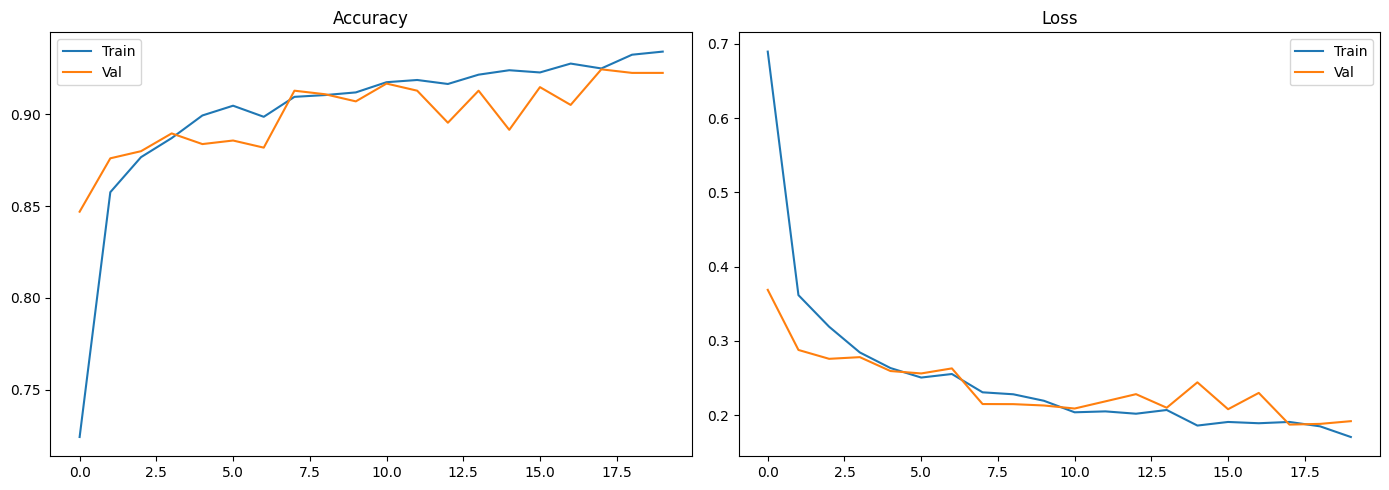

In [30]:
# =============================================================
# 📈 Cell 8 – Plot Accuracy & Loss
# =============================================================
def plot_history(hist):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Val')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

plot_history(history)


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step


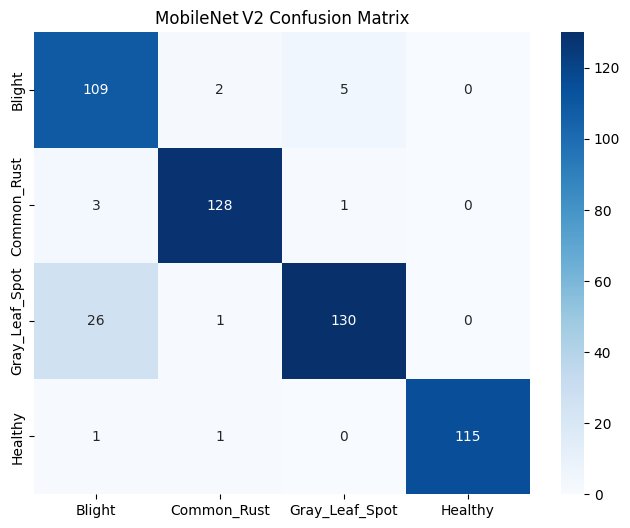

                precision    recall  f1-score   support

        Blight       0.78      0.94      0.85       116
   Common_Rust       0.97      0.97      0.97       132
Gray_Leaf_Spot       0.96      0.83      0.89       157
       Healthy       1.00      0.98      0.99       117

      accuracy                           0.92       522
     macro avg       0.93      0.93      0.93       522
  weighted avg       0.93      0.92      0.92       522



In [31]:
# =============================================================
# 🧮 Cell 9 – Evaluate & Confusion Matrix
# =============================================================
y_pred = model.predict(test_gen)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_cls)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('MobileNet V2 Confusion Matrix'); plt.show()

print(classification_report(y_true, y_pred_cls, target_names=labels))


In [32]:
# =============================================================
# ✅ Cell 10 – Final Train / Val / Test Accuracy
# =============================================================
print(f"Train Accuracy : {history.history['accuracy'][-1]*100:.2f}%")
print(f"Val   Accuracy : {history.history['val_accuracy'][-1]*100:.2f}%")
_, test_acc = model.evaluate(test_gen)
print(f"Test  Accuracy : {test_acc*100:.2f}%")


Train Accuracy : 93.41%
Val   Accuracy : 92.25%
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9242 - loss: 0.2101
Test  Accuracy : 92.34%



Class: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


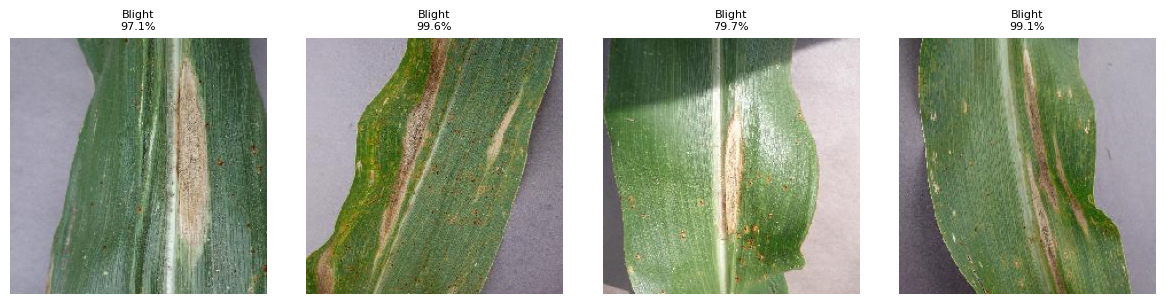


Class: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


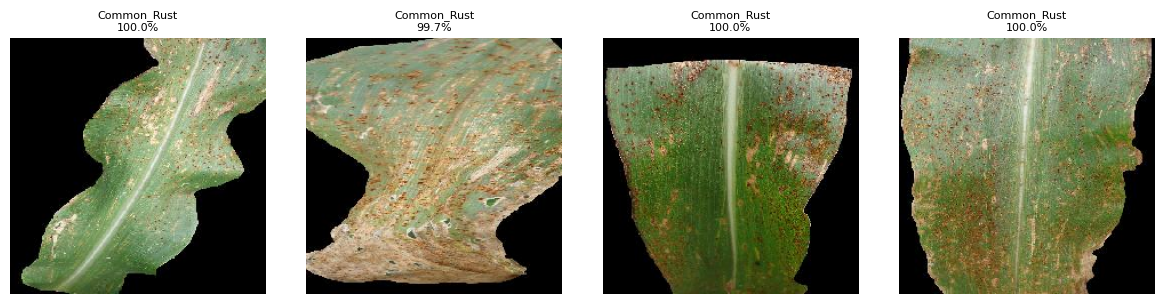


Class: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


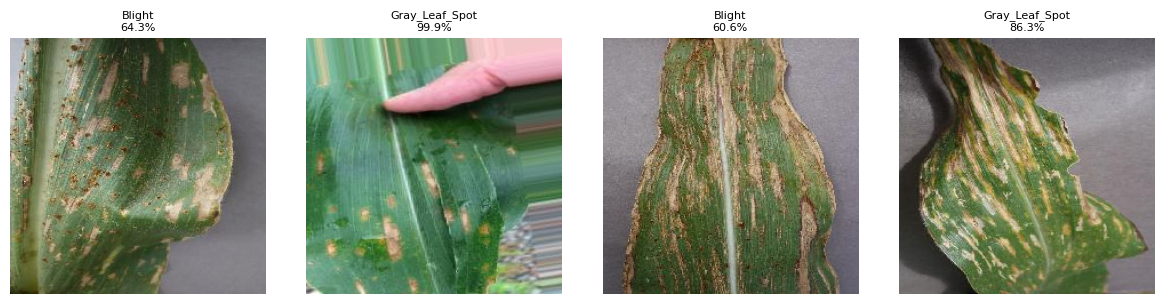


Class: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


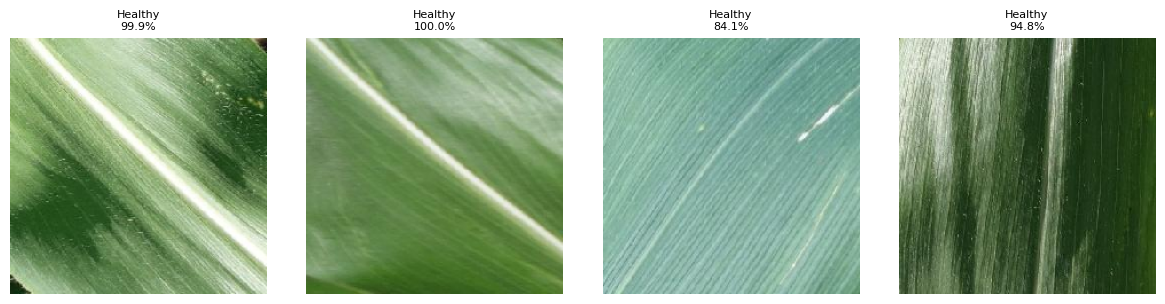

In [33]:
# =============================================================
# 🔍 Cell 11 – Predict Random Test Images
# =============================================================
for cls in labels:
    cls_path = os.path.join(test_path, cls)
    imgs = random.sample(
        [f for f in os.listdir(cls_path) if f.lower().endswith(('jpg','jpeg','png'))], 4)
    print(f"\nClass: {cls}")
    plt.figure(figsize=(12,3))
    for i, img_f in enumerate(imgs):
        p = os.path.join(cls_path, img_f)
        img = load_img(p, target_size=img_size)
        arr = img_to_array(img)/255.0
        pred = model.predict(np.expand_dims(arr,0))
        pred_cls = labels[np.argmax(pred)]
        conf = np.max(pred)*100
        plt.subplot(1,4,i+1)
        plt.imshow(img); plt.axis('off')
        plt.title(f'{pred_cls}\n{conf:.1f}%', fontsize=8)
    plt.tight_layout(); plt.show()


In [34]:
# Save the model
model.save('/content/drive/MyDrive/maize/maize_leaf_detection_mobilenet.h5')